In [12]:
import os
import re
import pandas as pd
from torchtext.data.functional import generate_sp_model, load_sp_model
import torch
from torch.utils.data import Dataset, DataLoader

In [118]:
print(type(line.split(",")))

<class 'list'>


In [126]:
root = "data"
with open(os.path.join(root, "train.csv")) as f:
        with open(os.path.join(root, "data.txt"), "w") as f2:
            for line in f:
                text_only = "".join(line.split(",")[1:])
                filtered = re.sub(r'\\|\\n|;', ' ', text_only.replace('"', ' ').replace('\n', ' '))
                filtered = filtered.replace(' #39;', "'")
                filtered = filtered.replace(' #38;', "&")
                filtered = filtered.replace(' #36;', "$")
                filtered = filtered.replace(' #151;', "-")
                f2.write(filtered.lower() + "\n")

In [122]:
# Generate the SentencePiece tokenizer
# Text tokenizer and detokenizer
# Unsupervised text tokenizer. It will tokenize words into subpieces instead of words
# This function will create a set of subtokens to fit the set vocabulary size
# There will always be enough subwords to subtokenize a dataset :)
# Saved in the home directory
generate_sp_model(os.path.join(root, "data.txt"), vocab_size=20000, model_prefix='transformer')

sentencepiece_trainer.cc(177) LOG(INFO) Running command: --input=data/data.txt --model_prefix=transformer --vocab_size=20000 --model_type=unigram
sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: data/data.txt
  input_format: 
  model_prefix: transformer
  model_type: UNIGRAM
  vocab_size: 20000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 0
  bos_id: 1
  eos_id: 2
  pad_id: -1
  unk_piece: <unk>
  bos_piece: <s>
  eos_piece: </s>
  pad_piece: <pad>
 

In [145]:
class AGNews(Dataset):
    def __init__(self, num_datapoints, set="train"):

        # Reads the file into a pandas DataFrame
        self.df = pd.read_csv(os.path.join(root, set + ".csv"), names=["Class", "Title", "Content"])

        # Replaces empty entries with a space
        self.df.fillna('', inplace=True)

        # Concatenates title and content into one heading 'article'
        self.df['Article'] = self.df['Title'] + " : " + self.df['Content']
        self.df.drop(['Title', 'Content'], axis=1, inplace=True)
        self.df['Article'] = self.df['Article'].str.replace(r'\\n|\\|\\r|\\r\\n|\n|"', ' ', regex=True)

        # Clean up data
        self.df['Article'] = self.df['Article'].replace({' #39;': "'", ' #38;': "&", ' #36;': "$", ' #151;': "-"}, regex=True)

        # Gets the first num_datapoints datapoints
        if num_datapoints is not None:
            self.df = self.df.head(num_datapoints)

    def __getitem__(self, index):
        text = self.df.loc[index]["Article"].lower()
        # See if we can remove array indexing
        class_index = int(self.df.loc[index]["Class"]) - 1
        return class_index, text

    def __len__(self):
        return len(self.df)

In [199]:
# Create training and testing datasets from train.csv, test.csv, using AGNews class
train_dataset = AGNews(num_datapoints=10000, set="train")
test_dataset = AGNews(num_datapoints=10000, set="test")

In [267]:
# Example dataset
train_dataset.df

,Class,Article
0,3,Wall St. Bears Claw Back Into the Black (Reute...
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...
4,3,"Oil prices soar to all-time record, posing new..."
...,...,...
9995,4,Winamp flaw: Digital attacks use skins for cam...
9996,4,BMC adds PeopleSoft management : BMC Software ...
9997,3,CAO chief faces Singapore probe : The chief of...
9998,3,A Microsoft deal gets full EU inquiry : BRUSSE...


In [265]:
test_dataset.df

,Class,Article
0,3,Fears for T N pension after talks : Unions rep...
1,4,The Race is On: Second Private Team Sets Launc...
2,4,Ky. Company Wins Grant to Study Peptides (AP) ...
3,4,Prediction Unit Helps Forecast Wildfires (AP) ...
4,4,Calif. Aims to Limit Farm-Related Smog (AP) : ...
...,...,...
7595,1,Around the world : Ukrainian presidential cand...
7596,2,Void is filled with Clement : With the supply ...
7597,2,Martinez leaves bitter : Like Roger Clemens di...
7598,3,5 of arthritis patients in Singapore take Bext...


In [203]:
# Create data loaders for the training and testing datasets
# Dataloaders allow for batching, shuffling

batch_size = 32  # Example batch size

dataloader_train = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
dataloader_test = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

In [283]:
# Tokenize individual entries
x = list(sp_tokenizer([text_batch[0]]))[0]
x

['▁facts',
 '▁on',
 '▁stem',
 '▁cells',
 '▁:',
 '▁this',
 '▁summer',
 '▁marks',
 '▁the',
 '▁third',
 '▁anniversary',
 '▁of',
 '▁president',
 '▁bush',
 "'",
 's',
 '▁announcement',
 '▁of',
 '▁his',
 '▁policy',
 '▁on',
 '▁stem',
 '▁cell',
 '▁research',
 '.',
 '▁in',
 '▁the',
 '▁interven',
 'ing',
 '▁years',
 ',',
 '▁the',
 '▁subject',
 '▁has',
 '▁become',
 '▁a',
 '▁polariz',
 'ing',
 '▁flash',
 '▁point',
 '▁for',
 '▁american',
 '▁politics',
 '▁and',
 '▁a',
 '▁f',
 'ocal',
 '▁point',
 '▁for',
 '▁the',
 '▁presidential',
 '▁campaign',
 '.']

In [281]:
from torchtext.data.functional import sentencepiece_tokenizer, sentencepiece_numericalizer
# Tokenization and numericalization

# Load the trained SentencePiece model
sp_model = load_sp_model("transformer.model")

# Create a tokenizer function from file
sp_tokenizer = sentencepiece_tokenizer(sp_model)

# Create a numericalizer function from file
sp_numericalizer = sentencepiece_numericalizer(sp_model)

# Example usage
for class_index, text_batch in data_loader_train:
    
    # text_batch is a list of sentences
    tokenized_text_batch = [list(sp_tokenizer([t]))[0] for t in text_batch]

    numericalized_text_batch = [list(sp_numericalizer([t]))[0] for t in text_batch]
    
    print(f"Original Text: {text_batch[0]}")
    
    print(f"Tokenized Text: {tokenized_text_batch[0]}")
    
    print(f"Numericalized Text: {numericalized_text_batch[0]}")
    
    break

Original Text: facts on stem cells : this summer marks the third anniversary of president bush's announcement of his policy on stem cell research. in the intervening years, the subject has become a polarizing flash point for american politics and a focal point for the presidential campaign.
Tokenized Text: ['▁facts', '▁on', '▁stem', '▁cells', '▁:', '▁this', '▁summer', '▁marks', '▁the', '▁third', '▁anniversary', '▁of', '▁president', '▁bush', "'", 's', '▁announcement', '▁of', '▁his', '▁policy', '▁on', '▁stem', '▁cell', '▁research', '.', '▁in', '▁the', '▁interven', 'ing', '▁years', ',', '▁the', '▁subject', '▁has', '▁become', '▁a', '▁polariz', 'ing', '▁flash', '▁point', '▁for', '▁american', '▁politics', '▁and', '▁a', '▁f', 'ocal', '▁point', '▁for', '▁the', '▁presidential', '▁campaign', '.']
Numericalized Text: [7795, 12, 2166, 3988, 665, 68, 1299, 3956, 3, 145, 2842, 8, 99, 165, 22, 7, 2060, 8, 40, 1001, 12, 2166, 764, 246, 4, 9, 3, 19774, 19, 131, 0, 3, 3304, 34, 681, 6, 19352, 19, 1973, 

In [319]:
text_batch[1]

"tjx cos. earnings fall 4 percent : tjx cos. inc.'s second-quarter earnings fell 4 percent, reflecting higher markdowns on merchandise due to softer sales trends. "

In [138]:
# https://pytorch.org/data/main/torchdata.datapipes.iter.html
# https://medium.com/deelvin-machine-learning/comparison-of-pytorch-dataset-and-torchdata-datapipes-486e03068c58

In [306]:
yield_tokens("transformer.vocab")

<generator object yield_tokens at 0x282a1c9a0>

In [304]:
def yield_tokens(file_path):
    with io.open(file_path, encoding='utf-8') as f:
        # Iterate through each line in the file
        for line in f:
            # Yield the token from the first column (split by tab)
            yield [line.split("\t")[0]]

# Build a vocabulary from the tokens yielded by the yield_tokens function
# <pad> is a padding token that is added to the end of a sentence to ensure the length of all sequences in a batch is the same
# <sos> signals the "Start-Of-Sentence" aka the start of the sequence
# <eos> signal the "End-Of-Sentence" aka the end of the sequence
# <unk> "unknown" token is used if a token is not contained in the vocab
# From torchtext library
# Builds a generator object, that is treated like an iterator
vocab = build_vocab_from_iterator(yield_tokens("transformer.vocab"), specials=['<pad>', '<sos>', '<eos>', '<unk>'], special_first=True)

# Set the default index for unknown tokens to the index of the '<unk>' token
vocab.set_default_index(vocab['<unk>'])

In [321]:
print(vocab['<pad>'])  # Should print the index of <pad>
print(vocab['<sos>'])  # Should print the index of <sos>
print(vocab['<eos>'])  # Should print the index of <eos>
print(vocab['<unk>'])  # Should print the index of <unk>
print(vocab['▁the'])   # Should print the index of ▁the (if present)
print(vocab['unknown_token'])  # Should print the index of <unk> as it's not in vocab

0
1
2
3
18412
3


In [372]:
# Data transform to turn text into vocab token
# Text transformation pipeline aliased T
text_transform = T.Sequential(
    # Tokenize with pretrained Tokenizer
    T.SentencePieceTokenizer("spm_ag_news.model"),
    # Converts the sentences to indices based on given vocabulary
    T.VocabTransform(vocab=vocab),
    # Add <sos> at beginning of each sentence. 1 because the index for <sos> in vocabulary is 1 as seen in previous section
    T.AddToken(1, begin=True),
    # Crop the sentence if it is longer than the max length
    T.Truncate(max_seq_len=max_len),
    ## Add <eos> at beginning of each sentence. 2 because the index for <eos> in vocabulary is
    # 2 as seen in previous section
    T.AddToken(2, begin=False),
    # Convert the list of lists to a tensor, this will also
    # Pad a sentence with the <pad> token if it is shorter than the max length
    # This ensures all sentences are the same length!
    T.ToTensor(padding_value=0),
)

text_transform

Sequential(
  (0): SentencePieceTokenizer()
  (1): VocabTransform(
    (vocab): Vocab()
  )
  (2): AddToken()
  (3): Truncate()
  (4): AddToken()
  (5): ToTensor()
)

In [374]:
class TokenDrop(nn.Module):
    """For a batch of tokens indices, randomly replace a non-specical token with <pad>.
    prob (float): probability of dropping a token
    pad_token (int): index for the <pad> token
    num_special (int): Number of special tokens, assumed to be at the start of the vocab
    """

    def __init__(self, prob=0.1, pad_token=0, num_special=4):
        self.prob = prob
        self.num_special = num_special
        self.pad_token = pad_token

    def __call__(self, sample):
        # Randomly sample a bernoulli distribution with p = prob
        # Create a mask where 1 means we will replace that token
        # Discrete probability distribution
        mask = torch.bernoulli(self.prob * torch.ones_like(sample)).long()
        
        # only replace if the token is not a special token
        # Ones or zeros. If false, zero, if true, 1
        can_drop = (sample >= self.num_special).long()
        # Multiply together to get the corresponding tokens that can be dropped, and that will be dropped
        mask = mask * can_drop

        # Make a mask of pad_token
        replace_with = (self.pad_token * torch.ones_like(sample)).long()

        # sample is the original sample
        # mask indicates what tokens can be replaced (0 to not be replaced, 1 to be replaced)
        # replace_with is a list of of the pad_token tokens
        # (1-mask) creates the complement mask. (now, 0 indicates to be replaced, 1 indicates to be not replaced)
        # Multiplying by sample, retains the original tokens that are not to be kept, and applies the mask on the sample
        # mask * replace_with does elementwise multiplication and adds the corresponding pad_token to the tokens replaced
        sample_out = (1 - mask) * sample + mask * replace_with
        
        return sample_out

# Sample tensor of token indices (e.g., a batch of sentences)
sample = torch.tensor([[5, 6, 7, 8], [9, 10, 11, 12]])

# Create an instance of TokenDrop with default parameters
token_drop = TokenDrop(prob=0.1, pad_token=0, num_special=4)

# Apply token dropping to the sample tensor
dropped_sample = token_drop(sample)

# Print the result
print(dropped_sample)

tensor([[ 5,  6,  7,  8],
        [ 9, 10, 11,  0]])


In [376]:
# Sinusoidal positional embeds
# Produce unique vector for the integer input vector
class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, x):
        device = x.device
        half_dim = self.dim // 2
        # Computes scaling factors
        emb = math.log(10000) / (half_dim - 1)
        # Generates sinusoidal frequencies
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        # Applies the frequencies to the posiitons
        emb = x[:, None] * emb[None, :]
        # Concatenates sin and cos functions to form positional embeddings
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)
        return emb


In [378]:
# Encoder-only Transformer
class NanoTransformer(nn.Module):
    """
    This class implements a simplified Transformer model for sequence classification. 
    It uses an embedding layer for tokens, sinusoidal positional embeddings, 
    a Transformer, and a Linear layer.

    Args:
      num_emb: The number of unique tokens in the vocabulary. (vocab_size)
      output_size: The size of the output layer (number of classes). (4)
      hidden_size: The dimension of the hidden layer in the Transformer block (default: 128)
      num_heads: The number of heads in the multi-head attention layer (default: 4).
    """
    def __init__(self, num_emb, output_size, hidden_size=128, num_heads=4):
        # Inherits from nn.Module's attributes
        super(NanoTransformer, self).__init__()

        # Create an embedding for each token
        self.embedding = nn.Embedding(num_emb, hidden_size)
        # Scaling down the embedding weights
        self.embedding.weight.data = 0.001 * self.embedding.weight.data
        # Positional embedding
        self.pos_emb = SinusoidalPosEmb(hidden_size)

        # Multi-head attention
        self.multihead_attn = nn.MultiheadAttention(hidden_size, num_heads=num_heads, batch_first=True)

        # Linear layer
        self.mlp = nn.Sequential(nn.Linear(hidden_size, hidden_size),
                                 nn.LayerNorm(hidden_size),
                                 nn.ELU(),
                                 nn.Linear(hidden_size, hidden_size))
        
        self.fc_out = nn.Linear(hidden_size, output_size)

    def forward(self, input_seq):
        # batch_size, length
        bs, l = input_seq.shape
        input_embs = self.embedding(input_seq)

        # Add a unique embedding to each token embedding depending on it's position in the sequence
        seq_indx = torch.arange(l, device=input_seq.device)
        pos_emb = self.pos_emb(seq_indx).reshape(1, l, -1).expand(bs, l, -1)
        embs = input_embs + pos_emb
        output, attn_map = self.multihead_attn(embs, embs, embs)

        output = self.mlp(output)

        return self.fc_out(output), attn_map

In [426]:
# Set the device to GPU if available, otherwise use CPU
device = torch.device(0 if torch.cuda.is_available() else 'cpu')

# Embedding size
hidden_size = 128

# Define the hyperparameters
# Learning rate for the optimizer
learning_rate = 1e-4

# Number of epochs for training
nepochs = 10

# Batch size for data loaders
batch_size = 32

# Maximum sequence length for text inputs
max_len = 128

# Create the Transformer model
tf_classifier = NanoTransformer(num_emb=len(vocab), output_size=4, hidden_size=hidden_size, num_heads=4).to(device)

# Initialize the optimizer
optimizer = optim.Adam(tf_classifier.parameters(), lr=learning_rate, weight_decay=1e-4)

# Cosine annealing scheduler to decay the learning rate
lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=nepochs, eta_min=0)

# Define the loss function
loss_fn = nn.CrossEntropyLoss()

# Custom transform to randomly replace a token with <pad>
td = TokenDrop(prob=0.1)

# Loggers for training and testing loss
training_loss_logger = []
test_loss_logger = []

# Loggers for training and testing accuracy
training_acc_logger = []
test_acc_logger = []

In [384]:
# Number of model parameters
num_model_params = 0
for param in tf_classifier.parameters():
    num_model_params += param.flatten().shape[0]

print("-This Model Has %d (Approximately %d Million) Parameters!" % (num_model_params, num_model_params//1e6))

-This Model Has 2660228 (Approximately 2 Million) Parameters!


In [442]:
for batch_idx, (labels, texts) in enumerate(data_loader_train):
    text_tokens = text_tranform(list(texts)).to(device)
    print(text_tokens.shape)
    if batch_idx == 0:
        break

torch.Size([32, 99])


In [444]:
# Initialize progress bar for tracking epochs
# pbar = trange(0, nepochs, leave=False, desc="Epoch")
train_acc = 0
test_acc = 0

# Loop over each epoch
for epoch in range(nepochs):
    # Update the progress bar with current training and testing accuracy
    print('Accuracy: Train %.2f%%, Test %.2f%%' %(train_acc * 100, test_acc * 100))
    
    # Set the model to training mode
    tf_classifier.train()
    steps = 0
    
    # Loop over each batch in the training dataset
    for batch_idx, (labels, texts) in enumerate(data_loader_train):
        # Number of examples in the batch
        bs = labels.shape[0]
        
        # Transform the text to tokens
        text_tokens = text_tranform(list(texts)).to(device)
        labels = labels.to(device)

        # TokenDrop
        text_tokens = td(text_tokens)

        # Get the model predictions
        pred, _ = tf_classifier(text_tokens)

        # Compute the loss using cross-entropy loss
        loss = loss_fn(pred[:, 0, :], labels)
        
        # Backpropagation and optimization step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Log the training loss
        training_loss_logger.append(loss.item())
        
        # Update training accuracy
        train_acc += (pred[:, 0, :].argmax(1) == labels).sum()
        steps += bs
    
    # Calculate average training accuracy
    train_acc = (train_acc / steps).item()
    training_acc_logger.append(train_acc)
    
    # Update learning rate
    lr_scheduler.step()
    
    # Set the model to evaluation mode
    tf_classifier.eval()
    steps = 0
    
    # Loop over each batch in the testing dataset
    with torch.no_grad():
        for batch_idx, (labels, texts) in enumerate(data_loader_train):
            bs = labels.shape[0]
            
            # Transform the text to tokens and move to the GPU
            text_tokens = text_tranform(list(texts)).to(device)
            labesl = labels.to(device)

            # Get the model predictions (Do not return attention map)
            pred, _ = tf_classifier(text_tokens)

            # Compute the loss using cross-entropy loss
            loss = loss_fn(pred[:, 0, :], labels)
            test_loss_logger.append(loss.item())

            # Update testing accuracy
            test_acc += (pred[:, 0, :].argmax(1) == labels).sum()
            steps += bs

        # Calculate average testing accuracy
        test_acc = (test_acc / steps).item()
        test_acc_logger.append(test_acc)

Accuracy: Train 0.00%, Test 0.00%
Accuracy: Train 25.93%, Test 27.05%
Accuracy: Train 27.78%, Test 27.66%


KeyboardInterrupt: 

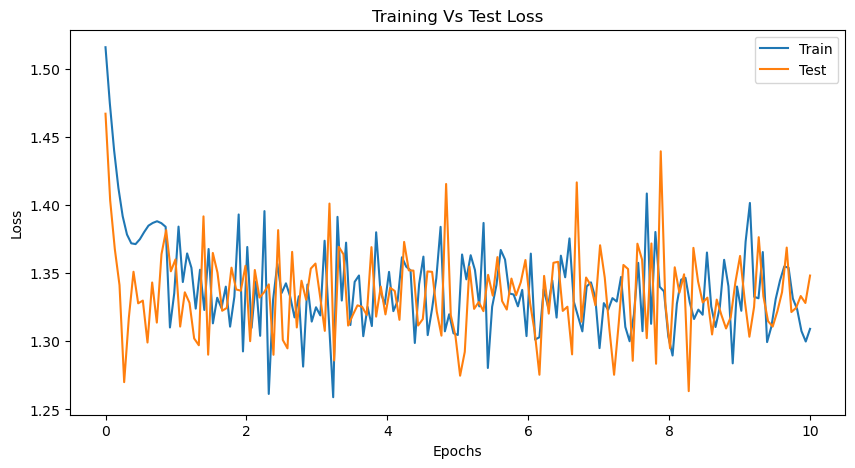

In [275]:
_ = plt.figure(figsize=(10, 5))
_ = plt.plot(np.linspace(0, nepochs, len(training_loss_logger)), training_loss_logger)
_ = plt.plot(np.linspace(0, nepochs, len(test_loss_logger)), test_loss_logger)

_ = plt.legend(["Train", "Test"])
_ = plt.title("Training Vs Test Loss")
_ = plt.xlabel("Epochs")
_ = plt.ylabel("Loss")

Max Test Accuracy 39.08%


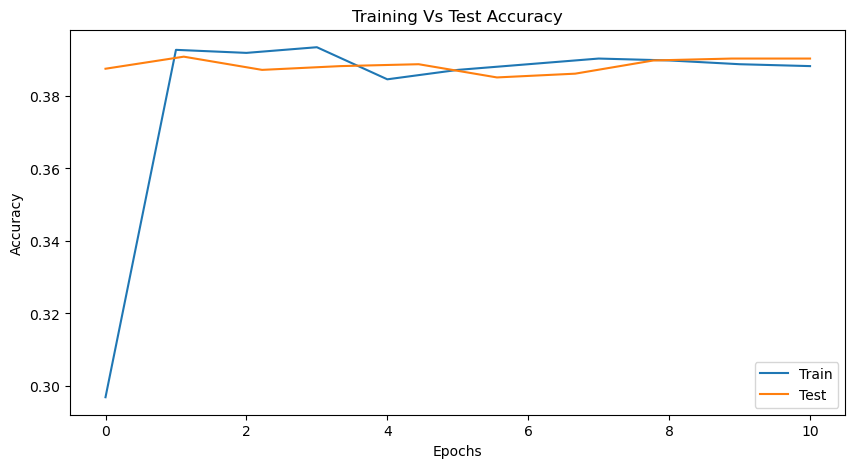

In [277]:
_ = plt.figure(figsize=(10, 5))
_ = plt.plot(np.linspace(0, nepochs, len(training_acc_logger)), training_acc_logger)
_ = plt.plot(np.linspace(0, nepochs, len(test_acc_logger)), test_acc_logger)

_ = plt.legend(["Train", "Test"])
_ = plt.title("Training Vs Test Accuracy")
_ = plt.xlabel("Epochs")
_ = plt.ylabel("Accuracy")
print("Max Test Accuracy %.2f%%" % (np.max(test_acc_logger) * 100))

In [279]:
ag_news_classes = [
    "World",
    "Sports",
    "Business",
    "Science/Technology"
]

with torch.no_grad():
    label, text = next(iter(data_loader_train))
    text_tokens = text_tranform(list(text)).to(device)
    pred, attention_map = tf_classifier(text_tokens)

In [281]:
test_index = 3

# Choose a text index smaller than the total number in the batch!
assert test_index < label.shape[0]

# Select the attention map for a single sample and the first attention head
att_map = attention_map[test_index, 0]
pred_class = ag_news_classes[pred[test_index, -1].argmax().item()]
top5 = att_map.argsort(descending=True)[:5]
top5_tokens = vocab.lookup_tokens(text_tokens[test_index, top5].cpu().numpy())


print("Article:")
print(text[test_index])
print("\nPredicted label:")
print(pred_class)
print("True label:")
print(ag_news_classes[label[test_index].item()])

print("\nTop 5 Tokens:")
print(top5_tokens)

Article:
sidebar: the nuts and bolts of com -- objects, interfaces and guids : a quick course in how some of the most esoteric aspects of com work.

Predicted label:
Science/Technology
True label:
Science/Technology

Top 5 Tokens:
['▁quick', '▁a', '<pad>', '<pad>', '<pad>']


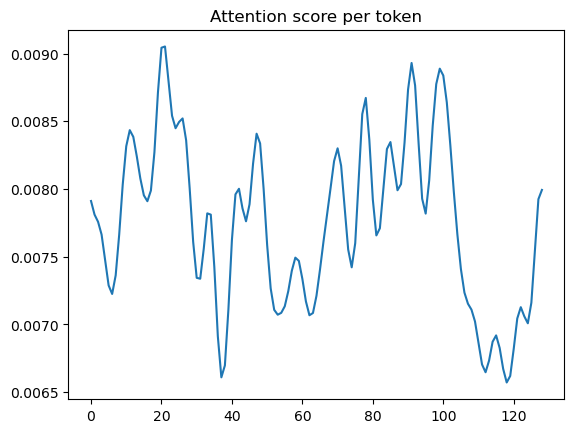

In [283]:
_ = plt.plot(att_map.cpu().numpy())
_ = plt.title("Attention score per token")